In [5]:
import sys
if '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages' not in sys.path:
    sys.path.insert(0, '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
    sys.path.insert(0, '/usr/users/vogg/FairMOT/src/lib')

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from collections import defaultdict

import _init_paths
from models.model import create_model, load_model
from models.decode import mot_decode, _nms, _topk, map2orig
#from tracking_utils.utils import *
from tracking_utils.kalman_filter import KalmanFilter
from tracker import matching
#from tracker.basetrack import BaseTrack, TrackState
from tracker.multitracker import MCTrack
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
from datasets.jde import letterbox

### Useful functions

In [11]:
def get_info(frame_num, heatmap_thres = 0.1, model_i = None, num_classes = 5):
    '''
    Selects a frame (given by frame_num) from the current video (cap).
    Returns the image, top detections from the heatmap and corresponding id_feature maps.
    
    '''
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, img0 = cap.read()
    
    # Scale and fill grey borders
    img_box, _, _, _ = letterbox(img0, height=608, width=1088)

    # Normalize RGB
    img = img_box[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img, dtype=np.float32)
    img /= 255.0

    im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

    width = img0.shape[1]
    height = img0.shape[0]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4
    
    
    with torch.no_grad():
        output = model_i(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']

    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)
    
    # translate and scale
    dets = map2orig(dets, h_out, w_out, height, width, 1)
    
    cls_detects_dict = defaultdict(list)
    cls_inds_dict = defaultdict(list)
    cls_id_feats = defaultdict(list)
    
    for cls_id in range(num_classes):  # cls_id starts from 0

        cls_inds = inds[:, cls_inds_mask[cls_id]]

        # gather feats for each object class
        cls_id_feature = _tranpose_and_gather_feat(id_feature, cls_inds)  # inds: 1×128
        cls_id_feature = cls_id_feature.squeeze(0)  # n × FeatDim
        cls_id_feature = cls_id_feature.cpu().numpy()
        
        
        
        cls_dets = dets[cls_id]
        cls_inds = inds[:, cls_inds_mask[cls_id]]

        # low threshold (0.01) to allow many potential detections
        remain_inds = cls_dets[:, 4] > heatmap_thres
        cls_dets = cls_dets[remain_inds]
        cls_inds = cls_inds[:, remain_inds]
        cls_inds = cls_inds.cpu().numpy().squeeze()
        cls_inds_dict[cls_id] = cls_inds

        #no_border_inds = ((cls_dets[:, 0] + cls_dets[:, 2]) / 2 > 0) & ((cls_dets[:, 0] + cls_dets[:, 2]) / 2 < img.shape[1]) & ((cls_dets[:, 1] + cls_dets[:, 3]) / 2 > 0) & ((cls_dets[:, 1] + cls_dets[:, 3]) / 2 < img.shape[0])
        #cls_dets = cls_dets[no_border_inds]
        cls_id_feature = cls_id_feature[remain_inds]
        #cls_id_feature = cls_id_feature[no_border_inds]

        cls_id_feats[cls_id] = cls_id_feature
        

        if len(cls_dets) > 0:
            '''Detections'''
            cls_detects = [MCTrack(MCTrack.tlbr_to_tlwh(tlbrs[:4]), tlbrs[4], feat, num_classes, cls_id, 3)
                for (tlbrs, feat) in zip(cls_dets[:, :5], cls_id_feature)]
        else:
            cls_detects = []
            
        cls_detects_dict[cls_id] = cls_detects


    return img_box, hm, cls_detects_dict, cls_inds, cls_id_feats


def plot_frame(img, hm = None, pred_hm = None, kalman = None, top_preds = False, thres = 0.01, text = False):
    '''
    Visualizes an image.
    If hm is a heatmap, then it visualizes the heatmap on top of the image with alpha = 0.5
    If pred_hm is a heatmap from a Kalman filter prediction, same as hm
    If top_preds is True, it shows the top detections which are above the threshold
    If text is True, then it visualizes the ID of the detection next to it.
    If Image is None, then it just visualizes the heatmap.
    '''
    fig, ax = plt.subplots(figsize=(12, 7))
    
    hm_alpha = 0.5 if img is not None else 0 if hm is None else 1
    
    if img is not None:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha = 1 - hm_alpha)
    if hm is not None:
        hm_local = hm.cpu()
        hm2 = _nms(hm_local)

        scores, inds, clses, ys, xs, _ = _topk(hm2, K = 50)
        hm_local = F.interpolate(hm_local, scale_factor = 4)
        hm_local = torch.squeeze(hm_local)
        
        ax.imshow(hm_local, alpha = hm_alpha)
    
        
    if pred_hm is not None:
        ax.imshow(pred_hm, alpha = pred_hm, cmap=plt.get_cmap('Reds'))
    if (top_preds == True) and (hm is not None):
        ax.scatter(xs[scores > thres] * 4, ys[scores > thres] * 4, s = 2, c = "red")
        for x, y, txt in zip(xs[scores > thres], ys[scores > thres], inds[scores > thres].numpy()):
            ax.text(x * 4, y * 4 ,txt, c = "white")
            
    plt.show()
    
    
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N
    
def plot_sim(dist_hm, inds, inds1, cell_text = False):
    fig, ax = plt.subplots(figsize = (10, 5))
    surf = plt.pcolormesh(dist_hm)
    plt.colorbar(surf)
    
    if cell_text:
        for y in range(dist_hm.shape[0]):
            for x in range(dist_hm.shape[1]):
                plt.text(x + 0.5, y + 0.5, '%.2f' % dists[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                         )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for y, ind in enumerate(inds):
        ax.text(-0.5, y, ind)
        max_y = y

    for x, ind in enumerate(inds1):
        ax.text(x, max_y + 1.2, ind)
        

def kalman_and_matching(tracks, detects):

    emb_dists = matching.embedding_distance(tracks, detects)
    iou_dists = matching.iou_distance(tracks, detects)
    dists = 0.5 * iou_dists + 0.5 * emb_dists


    matches, u_track, u_detection = matching.linear_assignment(dists, thresh=0.6)

    new_tracks = []
    
    for itracked, idet in matches:
        track = tracks[itracked]
        det = detects[idet]
        
        track.update(detects[idet], 1)
        new_tracks.append(track)

    
    
    return(emb_dists, iou_dists, dists, new_tracks, matches)

### Load model

In [12]:
model = create_model('hrnet_32', heads =  {'hm': 1, 'wh': 2, 'id': 128, 'reg': 2}, 
                     head_conv = 256, num_classes = 1, num_poses = None, 
                     clsID4Pose = None, cat_spec_wh = False, conf_thres = 0.1)

#model = load_model(model, '../models/mcqcp/model_150.pth')
model = load_model(model, '../models/hrnet/hrnet32_mcqcp150.pth')
model = model.to(torch.device('cuda'))
model.eval()
print('ok')

=> loading pretrained model /usr/users/vogg/FairMOT/models/hrnetv2_w32_imagenet_pretrained.pth
ok


### Load video

In [13]:
cap = cv2.VideoCapture("/usr/users/agecker/datasets/macaque_videos/Videos/VID_20210224_115729_0.mp4")
#cap = cv2.VideoCapture("/usr/users/agecker/datasets/derek_monkey_imgs/baboon_videos/DSCF0008.AVI")

### Review images and heatmaps

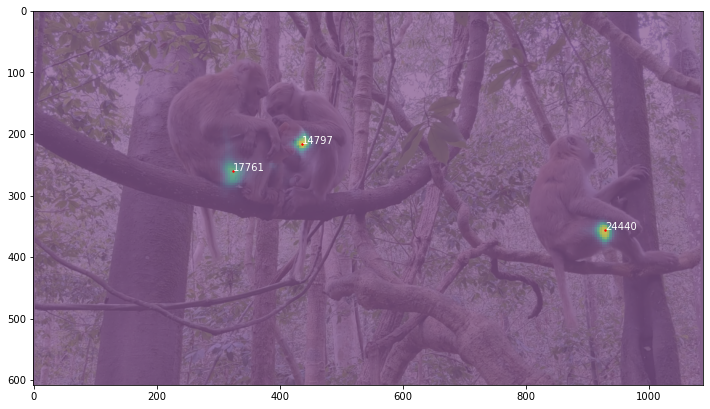

In [14]:
num_classes = 1
heatmap_thres = 0.4
sim_thres = 0.8
kalman_filter = KalmanFilter()

img, hm, dets, inds, cls_id_feats = get_info(150, 0.4, model, num_classes = num_classes)

tracks_dict = defaultdict(list)
inds_dict = defaultdict(list)

for cls_id in range(num_classes):  
    
    for track in dets[cls_id]:
        track.activate(kalman_filter, 0)
        tracks_dict[cls_id].append(track)

    #does not do anything here yet, because all velocities are 0
    MCTrack.multi_predict(tracks_dict[cls_id])



plot_frame(img = img, hm = hm, top_preds = True, thres = 0.4, text = True)

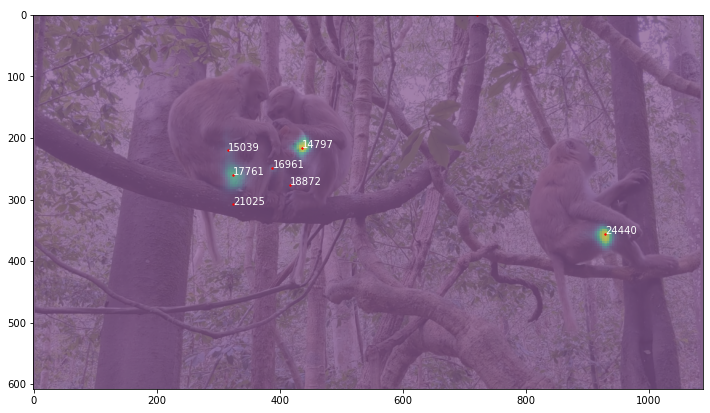

[OT_(0-4)_(0-1), OT_(0-5)_(0-1), OT_(0-6)_(0-1)]


In [15]:
img1, hm1, dets1, inds1, cls_id_feats1 = get_info(152, 0.02, model, num_classes)

new_tracks_dict = defaultdict(list)
new_inds_dict = defaultdict(list)

for cls_id in range(num_classes):  
    

    emb_dists, iou_dists, dists, new_tracks, matches = kalman_and_matching(tracks_dict[cls_id], dets1[cls_id])
    new_tracks_dict[cls_id] = new_tracks
    MCTrack.multi_predict(new_tracks)
    plot_frame(img1, hm1, top_preds = True, thres = 0.02)
    print(new_tracks)

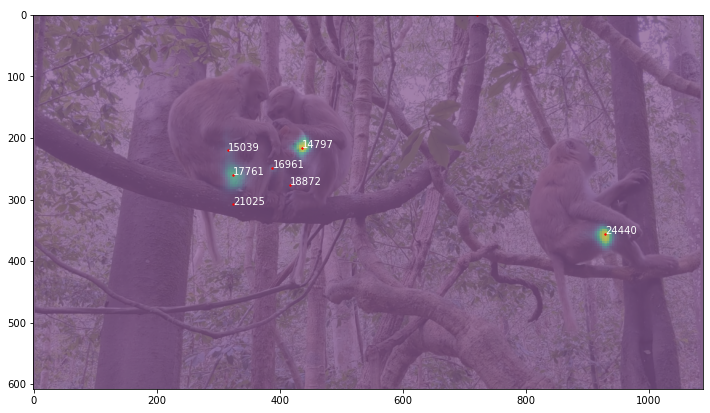

[OT_(0-4)_(0-1), OT_(0-5)_(0-1), OT_(0-6)_(0-1)]


In [16]:
img2, hm2, dets2, inds2, cls_id_feats2 = get_info(152, 0.02, model, num_classes)

new_tracks_dict = defaultdict(list)
new_inds_dict = defaultdict(list)
matches_dict = defaultdict(list)

for cls_id in range(num_classes):  
    

    emb_dists, iou_dists, dists, new_tracks, matches = kalman_and_matching(tracks_dict[cls_id], dets2[cls_id])
    new_tracks_dict[cls_id] = new_tracks
    matches_dict[cls_id] = matches
    MCTrack.multi_predict(new_tracks)
    plot_frame(img1, hm1, top_preds = True, thres = 0.02)
    print(new_tracks)

### Similarity matrices

First, we will get prior detections from the frame before.

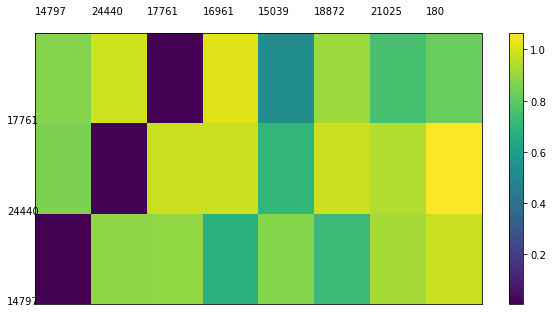

In [17]:
plot_sim(emb_dists, inds, inds1)

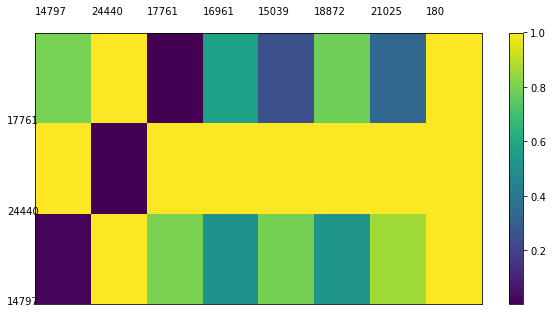

In [18]:
plot_sim(iou_dists, inds, inds1)

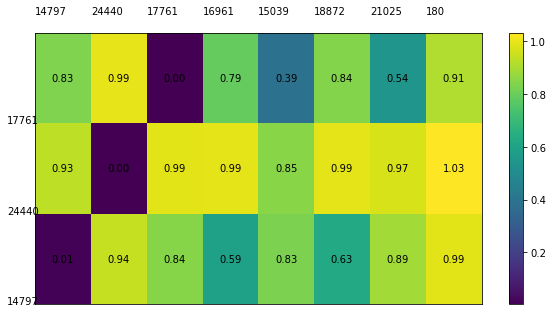

In [19]:
plot_sim(dists, inds, inds1, cell_text = True)

### Visualize Kalman Filter

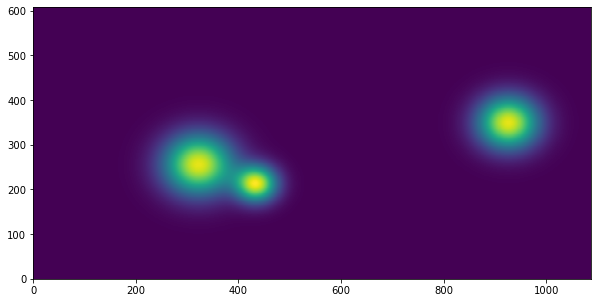

In [20]:
# Using the outputs from the kalman filter

empty_hm = torch.zeros((img1.shape[0], img1.shape[1]))
for itracked, idet in matches_dict[0]:
    track = tracks_dict[0][itracked]
    
    mu = [608, 1088] * track.mean[:2] / [1080, 1980]
    Sigma = [608, 1088] * track.covariance[:2, :2] / [1080, 1980]
    X = np.linspace(0, img1.shape[1], img1.shape[1])
    Y = np.linspace(0, img1.shape[0], img1.shape[0])
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_gaussian(pos, mu, Sigma)
    Z = 10 * Z / (np.max(Z) + 0.0000001)
    
    empty_hm = empty_hm + torch.from_numpy(Z)

empty_hm = empty_hm / torch.max(empty_hm)

fig, ax = plt.subplots(figsize = (10, 5))
surf = plt.pcolormesh(empty_hm)

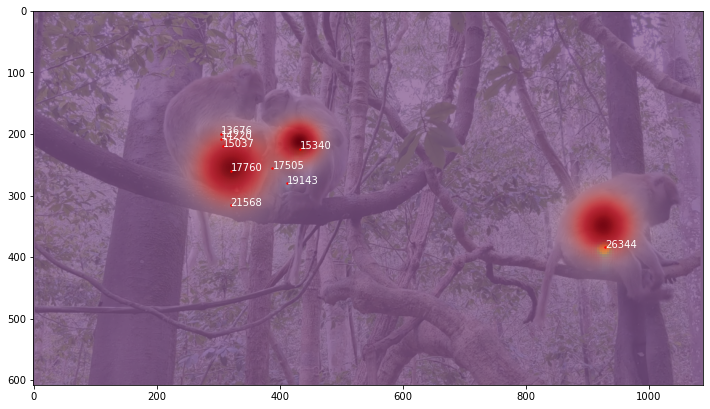

In [21]:
img1, hm1, dets1, inds1, cls_id_feats1 = get_info(300, 0.02, model, 1)
plot_frame(img = img1, hm = hm1, pred_hm = empty_hm, top_preds = True, thres = 0.02)

### Visualize Embeddings

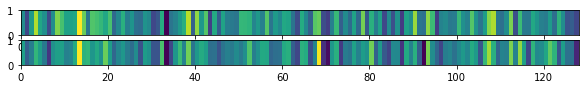

In [33]:
det = 15340 # for which object
track = 14797 # compare with which prior track

i = int(np.where(inds1 == det)[0])
j = int(np.where(inds == track)[0])
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 1))

ax2.pcolormesh(cls_id_feats1[0][i:(i+1),:])
ax1.pcolormesh(cls_id_feats[0][j:(j+1),:])